<a href="https://colab.research.google.com/github/Hoggnation/cataloging_coherent_oscillators/blob/main/Chi_Squared_Function_on_KIC_7917485.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install lightkurve
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [31]:
#this means only look at top ten frequencies/peaks
num_of_peaks = 10

In [32]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [33]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)

0.02043365134159103
48.938879463240205
0.02043365134159103


In [34]:
#check there is no unit
print(type(f_max_no_units), type(sampling_rate_days_no_units))

<class 'numpy.float64'> <class 'numpy.float64'>


In [35]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))

0.0006800582252348119
<class 'numpy.float64'>


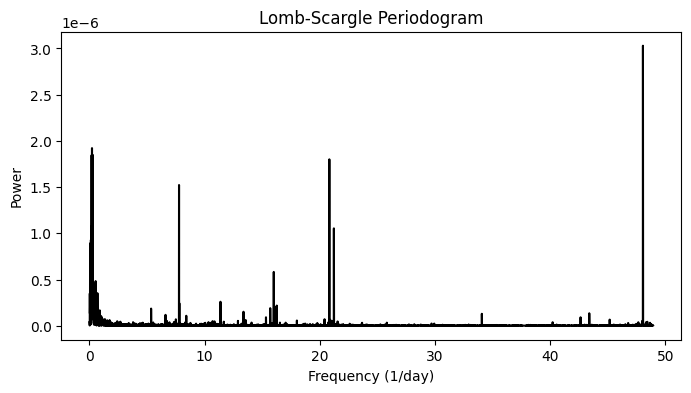

In [36]:
#trying to create periodograms with no units by manually plotting
#use lightcurve called lc to make periogram pg
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    minimum_frequency=f_min_no_units,
    maximum_frequency=f_max_no_units
)

power_no_units = np.array(pg.power.value) # an array of powers of the ligthcurve
freq_no_units = np.array(pg.frequency.value) # array of freqs of lightcurve
plt.figure(figsize=(8, 4))
plt.plot(freq_no_units, power_no_units, 'k-')  # Black line
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

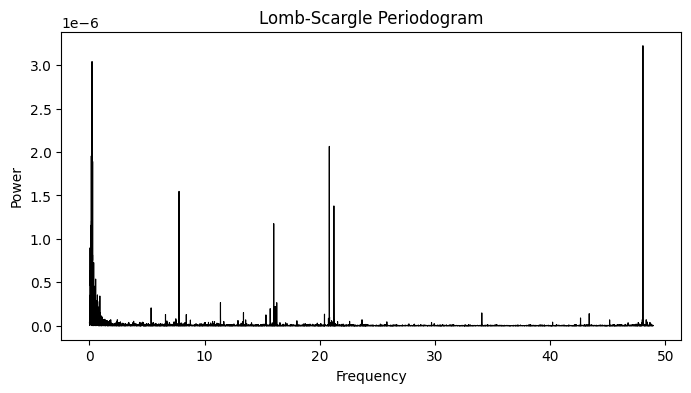

In [37]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()

In [38]:
import numpy as np
from scipy.signal import find_peaks

In [39]:
def get_started(num_of_peaks, xs, ys):
    """

    Identifies and returns the indices of the highest peaks in a given dataset.

    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array


    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [40]:
indices = get_started(num_of_peaks, freq_values, power_values)
print(indices)

[70662   329   283   308 30623   236   404   376 11436 31207]


In [41]:
def check_inputs(xs):
    """

    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.

    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

In [42]:
def reorder_inputs(xs,ys):
    """

    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length

    """
    i = np.argsort(xs)
    return xs[i], ys[i]


In [43]:
#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist):
    """

    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered

    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

In [44]:
def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak


    Returns:
        tuple: (b, m, q)

    Bugs:
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array


    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

In [45]:
def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak

    Returns:
        tuple: (x position of refined peak, y position of refined peak)

    Bugs:
        Must be synchronized with the design matrix


    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b

In [46]:
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        tuple of numpy arrays (array of refined x positions, array of refined y positions


    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined)

In [47]:
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices) # this returns the new x values
#and the new y values

In [48]:
print (new_freqs, new_powers)

[48.05475521  0.22467758  0.19316354  0.21025306 20.82583281  0.1615085
  0.27557164  0.25647415  7.77780489 21.22323902] [3.23032276e-06 3.04926063e-06 3.01287734e-06 2.20810321e-06
 2.07275311e-06 1.96647188e-06 1.89357902e-06 1.73434158e-06
 1.54695314e-06 1.37923269e-06]


In [49]:
#originally the new positions function was returning the refined peaks and powers as seperate arrays, now they are arranged as tuples so that the zip function works
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices)
new_positions = list(zip(new_freqs, new_powers))
refined_frequencies, refined_powers = zip(*new_positions)

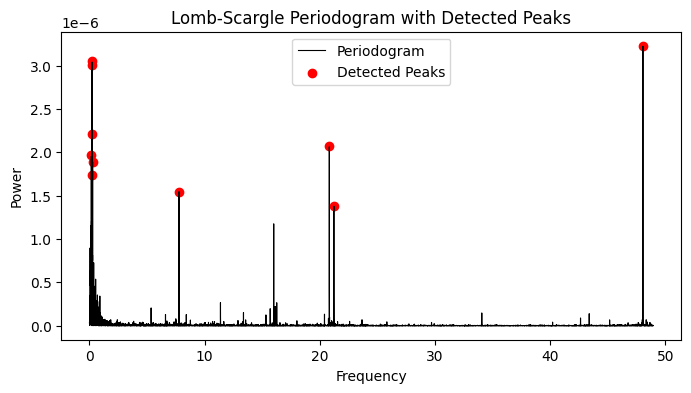

In [50]:
plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(refined_frequencies, refined_powers, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()

In [64]:
#array of time differences, find its median, use it to calculate the max frequency
search_result = lk.search_lightcurve('KIC_7917485', mission='Kepler')
lc_collection = search_result.download_all()

0.020433651749044657
48.93887848738312
0.020433651749044657


NameError: name 'KIC_7917485' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:

lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)

plt.figure(figsize=(10, 5))
lc.plot(label=f"Kepler {KIC_7917485}", marker='.', linestyle='none')
plt.title(f"Light Curve of {KIC_7917485}")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux")
plt.grid()
plt.show()

In [52]:
# Arrays for time, flux, uncertainity, and selecting our frequency from the refined peaks
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
max_power_index = np.argmax(new_powers)
nu = new_freqs[max_power_index]

In [63]:
print(t.shape, flux.shape, sigma.shape)

(473,) (473,) (473,)


In [53]:
# Masking the arrays to ensure all arrays are the same length(had error due to unmatched data lengths)
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = ~np.isnan(t_clean) & ~np.isnan(flux_clean) & ~np.isnan(sigma_clean) #good

t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]


In [58]:

print(t_fit.shape, flux_fit.shape, sigma_fit.shape)

(469,) (469,) (469,)


In [55]:
print(t_fit.max(), flux_fit.max(), sigma_fit.max())

130.24486033071298 1.0070231 0.00011507765


In [56]:
# Computing angular frequency to transform the time values into periodic positions along the sinudoidal curve
omega = 2 * np.pi * nu

# Design matrix
A_matrix = np.vstack([
    np.ones_like(t_fit),                   # Constant offset C which positions the sinuoidal curve at the right height on the model
    np.cos(omega * t_fit),
    np.sin(omega * t_fit)
]).T

# Matrix of our uncertainities(covariance i believe)
W = np.diag(1 / sigma_fit**2)

# These should be the matrices as described by the paper
ATA = A_matrix.T @ W @ A_matrix
ATy = A_matrix.T @ W @ flux_fit
g = np.linalg.solve(ATA, ATy)

# g[0] = C is the constant C, g[1] = A is the amplitude of the cosine term , g[2]=B is the amplitude of the sine term

# Applying the values we got for A, B, and C to obtain our model
model_flux = A_matrix @ g



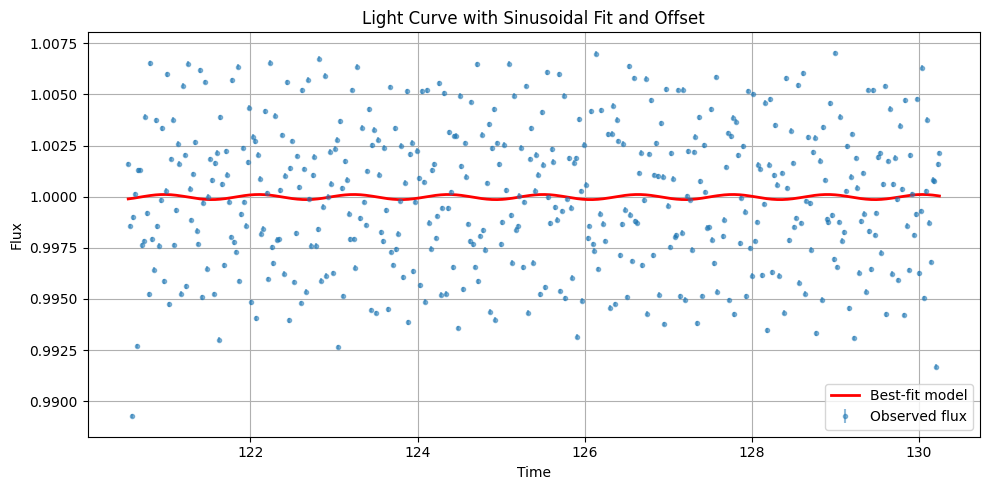

In [57]:
plt.figure(figsize=(10, 5))
plt.errorbar(t_fit, flux_fit, yerr=sigma_fit, fmt='.', label='Observed flux', alpha=0.5)
plt.plot(t_fit, model_flux, color='red', label='Best-fit model', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve with Sinusoidal Fit and Offset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Amplitude of model seems off